#### Foundations of Machine Learning Aug-Nov 2024
##### Sakshi Badole CS24MTECH11008
##### Assignment 4
##### Question 6: __Kaggle: House Price Prediction__ 
Model one: 0.13062 and Model two: 0.12803

The descriptions of the models are provided in the report

#### Model One : score of ***0.13062*** on Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from category_encoders import TargetEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

In [74]:
#0.13055
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Save target variable for training data
train_labels = np.log1p(train_df['SalePrice'])

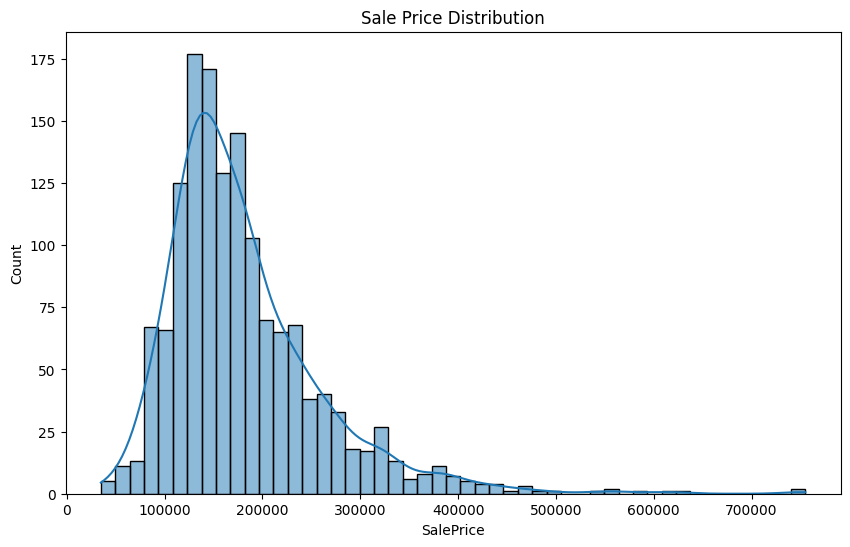

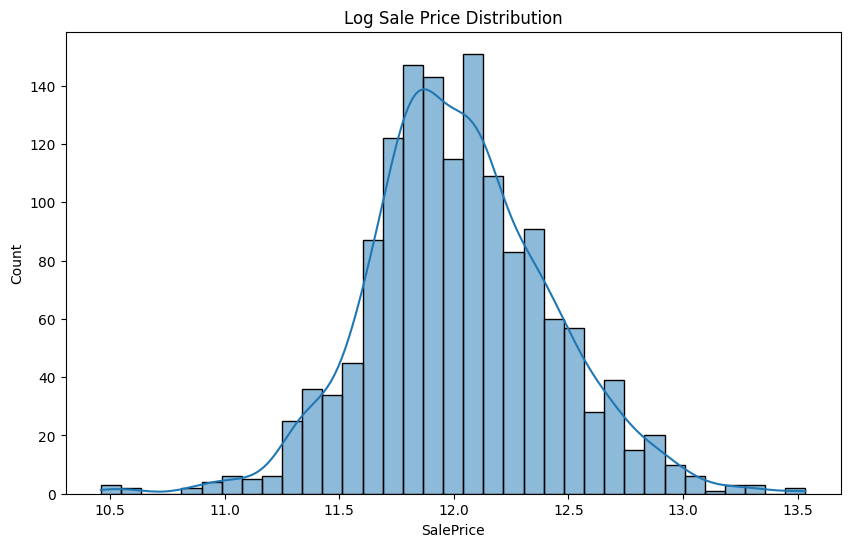

In [75]:
# Plot sale price distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['SalePrice']), kde=True)
plt.title('Log Sale Price Distribution')
plt.show()

In [76]:
# Drop target column from training data
train_df.drop('SalePrice', axis=1, inplace=True)

In [77]:
# Feature Engineering Functions
def preprocess_data(df, is_train=True):
    # Handle missing numerical values
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_features:
        df[col].fillna(df[col].mean(), inplace=True)

    # Handle missing categorical values
    categorical_features = df.select_dtypes(include=['object']).columns
    for col in categorical_features:
        df[col].fillna('None', inplace=True)

    # Feature Engineering
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] +
                            0.5 * df['HalfBath'] +
                            df['BsmtFullBath'] +
                            0.5 * df['BsmtHalfBath'])
    df['TotalPorchSF'] = (df['OpenPorchSF'] +
                          df['EnclosedPorch'] +
                          df['3SsnPorch'] +
                          df['ScreenPorch'])
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['GarageAge'].fillna(0, inplace=True)
    return df

In [78]:
# Preprocess training and test datasets 
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df, is_train=False)

C:\Users\sakshi badole\AppData\Local\Temp\ipykernel_24700\3264237124.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\sakshi badole\AppData\Local\Temp\ipykernel_24700\3264237124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [79]:
# Aligning train and test datasets by ensuring they have the same columns

missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0


missing_cols = set(test_df.columns) - set(train_df.columns)
for col in missing_cols:
    train_df[col] = 0


# Ensure the same column order in both datasets
train_df = train_df[test_df.columns]

In [80]:
# Encode categorical features using Target Encoding
categorical_features = train_df.select_dtypes(include=['object']).columns

encoder = TargetEncoder(cols=categorical_features)
train_df[categorical_features] = encoder.fit_transform(train_df[categorical_features], train_labels)
test_df[categorical_features] = encoder.transform(test_df[categorical_features])

In [81]:
# Log transform skewed numerical features
numeric_feats = train_df.select_dtypes(include=['int64', 'float64']).columns
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]

for feat in skewed_feats.index:
    train_df[feat] = np.log1p(train_df[feat])
    test_df[feat] = np.log1p(test_df[feat])

In [82]:
# Scale Features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
X_test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)


In [83]:
#  Training and Evaluation

def train_model(model, X, y, model_name):
    # Train model
    model.fit(X, y)

    # Make predictions
    predictions = model.predict(X)

    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())

    print(f"{model_name} RMSE: {rmse:.4f}")
    return model, predictions

In [ ]:
# Define base models
base_models = [
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
]


In [85]:
# Define the meta-model
meta_model = Ridge(alpha=1.0)

In [86]:
# Define the stacking model
stack_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

In [87]:
# Train and evaluate the stacking model
stack_model.fit(X_train, train_labels)
cv_scores = cross_val_score(stack_model, X_train, train_labels, cv=5, scoring='neg_mean_squared_error')
stack_rmse = np.sqrt(-cv_scores.mean())
print(f"Stacking Model RMSE: {stack_rmse:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4485
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 81
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4172
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 78
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4195
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 80
[LightGBM] [Info] Start trai

In [88]:
# Predict on test data
stack_test_preds = np.expm1(stack_model.predict(X_test))

In [89]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': stack_test_preds
})
submission.to_csv('Model1_submission.csv', index=False)


___

___

#### Model two : score of ***0.12803*** on Kaggle

In [50]:
#0.12803 with 0.05 corr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [52]:
# Save the 'Id' column from the test dataset
test_ids = test_df['Id']

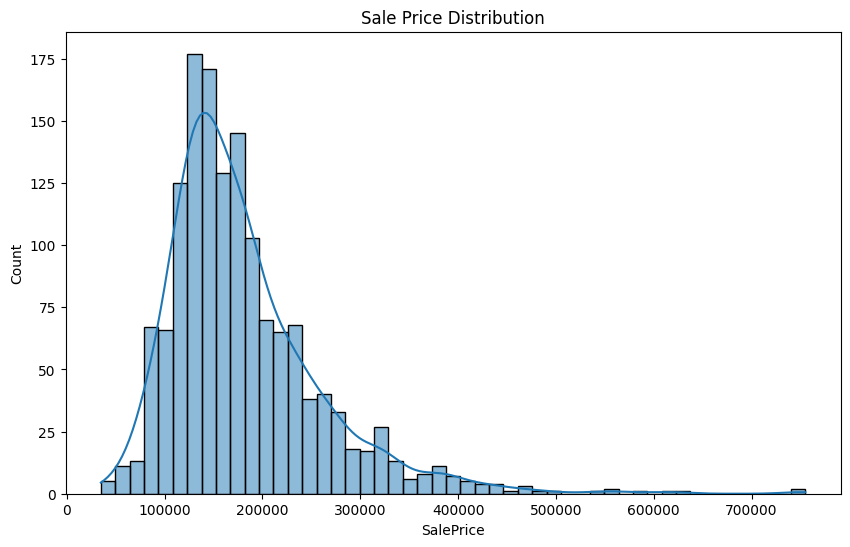

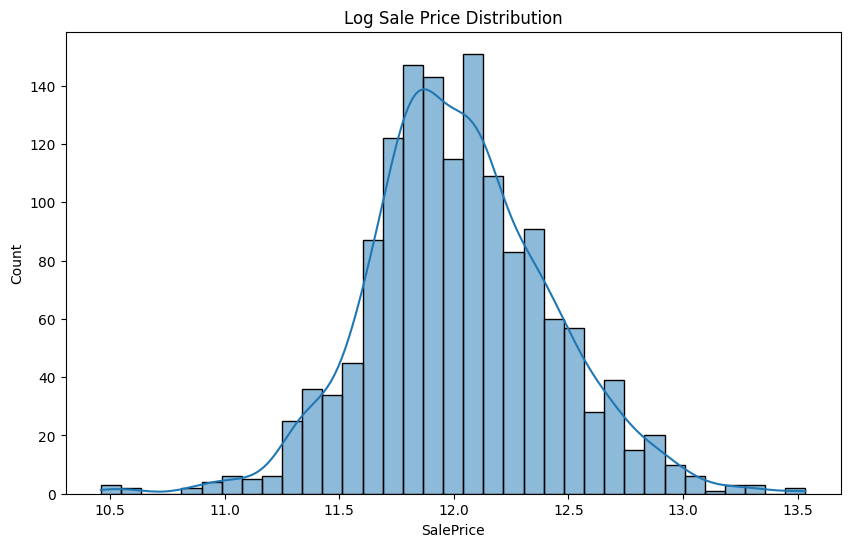

In [53]:
# Plot sale price distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['SalePrice']), kde=True)
plt.title('Log Sale Price Distribution')
plt.show()

In [54]:
# Save target variable
train_labels = np.log1p(train_df['SalePrice'])

In [55]:
# Feature Engineering
def feature_engineering(df):
    # Print the columns for debugging
    print("Columns before feature engineering:", df.columns)

    # Aggregated neighborhood features
    neighborhood_price_map = train_df.groupby("Neighborhood")["SalePrice"].mean()
    df["NeighborhoodPrice"] = df["Neighborhood"].map(neighborhood_price_map)

    if 'TotalBsmtSF' in df.columns and '1stFlrSF' in df.columns and '2ndFlrSF' in df.columns:
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    else:
        print("Some expected columns are missing: TotalBsmtSF, 1stFlrSF, or 2ndFlrSF")

    # Interaction features
    df['Qual_SF'] = df['OverallQual'] * df['GrLivArea']
    df['Cond_SF'] = df['OverallCond'] * df['TotalSF']

    # Cyclic encoding of months
    df['MoSold_sin'] = np.sin(2 * np.pi * df['MoSold'] / 12)
    df['MoSold_cos'] = np.cos(2 * np.pi * df['MoSold'] / 12)

    return df

In [56]:
# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

Columns before feature engineering: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQua

In [57]:
# Print the columns after feature engineering
print("Columns after feature engineering:", train_df.columns)

Columns after feature engineering: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual

In [58]:
# Preprocessing
def preprocess_data(df):
    # Handle missing numerical values
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_features:
        df[col].fillna(df[col].mean(), inplace=True)

    # Handle missing categorical values
    categorical_features = df.select_dtypes(include=['object']).columns
    for col in categorical_features:
        df[col].fillna('None', inplace=True)

    # One-hot encode categorical features
    df = pd.get_dummies(df, drop_first=True)

    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

C:\Users\sakshi badole\AppData\Local\Temp\ipykernel_24700\2594206648.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\sakshi badole\AppData\Local\Temp\ipykernel_24700\2594206648.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [59]:
# Function to drop low-correlation features
def drop_low_correlation_features(df, target_column, threshold):
    # Compute correlations with the target variable
    correlations = df.corr()[target_column].drop(target_column)
    abs_correlations = correlations.abs()

    # Print the correlation values for inspection
    print("\nCorrelation values with target variable (absolute):")
    print(abs_correlations.sort_values(ascending=False))

    # Identify features to drop based on the threshold
    low_correlation_features = abs_correlations[abs_correlations < threshold].index

    # Drop the identified features
    df = df.drop(columns=low_correlation_features)
    print(f"\nDropped features with correlation below {threshold}: {list(low_correlation_features)}")

    return df

# Drop low-correlation features from the training set 
threshold = 0.05  
train_df = drop_low_correlation_features(train_df, 'SalePrice', threshold)




Correlation values with target variable (absolute):
Qual_SF              0.832057
OverallQual          0.790982
TotalSF              0.782260
NeighborhoodPrice    0.738630
GrLivArea            0.708624
                       ...   
Foundation_Wood      0.002711
GarageCond_Gd        0.000983
RoofStyle_Mansard    0.000308
RoofMatl_Metal       0.000304
BsmtFinType2_GLQ     0.000076
Name: SalePrice, Length: 267, dtype: float64

Dropped features with correlation below 0.05: ['Id', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold', 'MoSold_cos', 'Street_Pave', 'Alley_Pave', 'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_SawyerW', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition

In [60]:
# Align train and test datasets
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

In [61]:
# Separate features and target
X_train = train_df.drop(['SalePrice'], axis=1)
X_test = test_df

In [62]:

if 'SalePrice' in X_test.columns:
    X_test = X_test.drop(['SalePrice'], axis=1)

In [63]:
# Model Training
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

model_predictions = {}
cv_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, train_labels)
    preds = model.predict(X_train)
    model_predictions[name] = preds
    score = -cross_val_score(model, X_train, train_labels, cv=5, scoring='neg_mean_squared_error').mean()
    cv_scores[name] = np.sqrt(score)
    print(f"{name} CV RMSE: {cv_scores[name]:.5f}")


Training RandomForest...
RandomForest CV RMSE: 0.13395

Training GradientBoosting...
GradientBoosting CV RMSE: 0.12510

Training XGBoost...
XGBoost CV RMSE: 0.13672

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 152
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3842
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 151
[LightGBM] [Info] St

In [64]:
# Weighted Stacking
def optimize_weights(weights):
    blended_preds = np.sum([weights[i] * model_predictions[name] for i, name in enumerate(models)], axis=0)
    rmse = np.sqrt(mean_squared_error(train_labels, blended_preds))
    return rmse

initial_weights = [1 / len(models)] * len(models)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * len(models)

optimized_result = minimize(optimize_weights, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_result.x

print("\nOptimized Weights:", optimized_weights)


Optimized Weights: [0.25000154 0.24999996 0.24999658 0.25000192]


In [65]:
# Final Prediction with Optimized Weights
test_predictions = np.sum([optimized_weights[i] * models[name].predict(X_test) for i, name in enumerate(models)], axis=0)


In [66]:
# Create Submission File  
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': np.expm1(test_predictions)
})
submission.to_csv('Model2_submission.csv', index=False)
print("\nSubmission file created!")



Submission file created!
